# Machine Learning for Multi-Omics Biology

This notebook demonstrates key ML concepts for biological data analysis using the ASD multi-omics dataset.

**Sections:**
1. Fundamental ML Concepts
2. Model Performance Metrics
3. LazyPredict Framework
4. Feature Importance Methods
5. Feature Selection for Biomarker Discovery

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE, SelectFromModel, mutual_info_classif
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, 
                             precision_score, recall_score, average_precision_score)
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [40]:
# Load the ASD multi-omics dataset
DATA_DIR = "../data/ASD_dataset/"

print("Loading ASD multi-omics dataset...\n")

# Load covariates (includes target variable 'ASD')
covariates = pd.read_csv(f"{DATA_DIR}ASD_covariates.csv")
print(f"✓ Covariates: {covariates.shape[0]} samples, {covariates.shape[1]} variables")

# Load genotype data (SNPs)
genotypes = pd.read_csv(f"{DATA_DIR}ASD_genotypes.csv")
print(f"✓ Genotypes: {genotypes.shape[0]} samples, {genotypes.shape[1]-1} SNPs")

# Load gene expression data
expression = pd.read_csv(f"{DATA_DIR}ASD_expression.csv")
print(f"✓ Expression: {expression.shape[0]} samples, {expression.shape[1]-1} genes")

# Set sample ID as index for easy merging
covariates_idx = covariates.set_index('sample')
genotypes_idx = genotypes.set_index('sample')
expression_idx = expression.set_index('sample')

# Create integrated feature matrix (multi-omics integration)
X_integrated = pd.DataFrame(index=expression_idx.index)

# Add gene expression features (prefix with expr_)
for gene in expression_idx.columns:
    X_integrated[f'{gene}'] = expression_idx[gene]

# Add top 10 SNP features (prefix with geno_)
for snp in genotypes_idx.columns[:10]:
    X_integrated[f'geno_{snp}'] = genotypes_idx[snp]

# Add clinical covariates
X_integrated['Age'] = covariates_idx['Age']
X_integrated['Sex'] = covariates_idx['Sex']

# Target variable: ASD status (1=case, 0=control)
y = covariates_idx['ASD'].values

print(f"\n✓ Integrated feature matrix: {X_integrated.shape}")
print(f"✓ Target distribution: {y.sum()} ASD cases, {len(y)-y.sum()} controls")
print(f"  Class ratio: {y.mean():.1%} cases")

Loading ASD multi-omics dataset...

✓ Covariates: 300 samples, 29 variables
✓ Genotypes: 300 samples, 50 SNPs
✓ Expression: 300 samples, 100 genes

✓ Integrated feature matrix: (300, 112)
✓ Target distribution: 200 ASD cases, 100 controls
  Class ratio: 66.7% cases


# Section 1: Fundamental ML Concepts

Demonstrates:
- Train/Test split with stratification
- Cross-validation
- Standardization vs Normalization
- Overfitting detection
- Regularization

In [41]:
# 1.1 Train-Test Split with Stratification
# Split data 70-30, preserving class proportions
print("=" * 80)
print("TRAIN-TEST SPLIT WITH STRATIFICATION")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_integrated, y,
    test_size=0.3,      # 30% for testing
    stratify=y,         # Preserve class proportions
    random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"  ASD cases: {y_train.sum()} ({y_train.mean():.1%})")
print(f"  Controls: {len(y_train)-y_train.sum()} ({(1-y_train.mean()):.1%})")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  ASD cases: {y_test.sum()} ({y_test.mean():.1%})")
print(f"  Controls: {len(y_test)-y_test.sum()} ({(1-y_test.mean()):.1%})")

print("\n✓ Class proportions preserved in both sets!")

TRAIN-TEST SPLIT WITH STRATIFICATION

Training set: 210 samples
  ASD cases: 140 (66.7%)
  Controls: 70 (33.3%)

Test set: 90 samples
  ASD cases: 60 (66.7%)
  Controls: 30 (33.3%)

✓ Class proportions preserved in both sets!


In [42]:
# 1.2 Standardization vs Normalization Example
# Using a gene with wide range to demonstrate difference
print("=" * 80)
print("STANDARDIZATION VS NORMALIZATION")
print("=" * 80)

# Select a gene for demonstration
example_gene = X_train.iloc[:, 0]  # First gene
print(f"\nExample gene: {X_train.columns[0]}")
print(f"Original range: [{example_gene.min():.2f}, {example_gene.max():.2f}]")
print(f"Mean: {example_gene.mean():.2f}, Std: {example_gene.std():.2f}")

# Standardization (Z-score): mean=0, std=1
scaler_standard = StandardScaler()
gene_standardized = scaler_standard.fit_transform(example_gene.values.reshape(-1, 1)).flatten()

print(f"\nAfter STANDARDIZATION:")
print(f"  Range: [{gene_standardized.min():.2f}, {gene_standardized.max():.2f}]")
print(f"  Mean: {gene_standardized.mean():.2f}, Std: {gene_standardized.std():.2f}")

# Normalization (Min-Max): range [0, 1]
scaler_minmax = MinMaxScaler()
gene_normalized = scaler_minmax.fit_transform(example_gene.values.reshape(-1, 1)).flatten()

print(f"\nAfter NORMALIZATION:")
print(f"  Range: [{gene_normalized.min():.2f}, {gene_normalized.max():.2f}]")
print(f"  Mean: {gene_normalized.mean():.2f}, Std: {gene_normalized.std():.2f}")

print("\n✓ Standardization preferred for biology (robust to outliers)")

# Apply standardization to entire dataset
# CRITICAL: Fit on training, transform on test!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling

print("\n✓ All features standardized (fit on train, applied to test)")

STANDARDIZATION VS NORMALIZATION

Example gene: CNTNAP2
Original range: [0.00, 40.00]
Mean: 9.30, Std: 6.81

After STANDARDIZATION:
  Range: [-1.37, 4.52]
  Mean: -0.00, Std: 1.00

After NORMALIZATION:
  Range: [0.00, 1.00]
  Mean: 0.23, Std: 0.17

✓ Standardization preferred for biology (robust to outliers)

✓ All features standardized (fit on train, applied to test)


In [43]:
# 1.3 Cross-Validation Example
# Demonstrate stratified K-fold CV
print("=" * 80)
print("CROSS-VALIDATION")
print("=" * 80)

# Create a simple model for demonstration
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc')

print(f"\n5-Fold Cross-Validation AUC scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\n✓ CV provides robust performance estimate!")

CROSS-VALIDATION

5-Fold Cross-Validation AUC scores:
  Fold 1: 0.8750
  Fold 2: 0.9745
  Fold 3: 0.8520
  Fold 4: 0.8878
  Fold 5: 0.8367

Mean AUC: 0.8852 ± 0.0480

✓ CV provides robust performance estimate!


In [44]:
# 1.4 Detecting Overfitting
# Compare training vs test performance
print("=" * 80)
print("OVERFITTING DETECTION")
print("=" * 80)

# Train model
rf_model.fit(X_train_scaled, y_train)

# Get probabilities for training set
y_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

# Get probabilities for test set  
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC:     {test_auc:.4f}")
print(f"Difference:   {train_auc - test_auc:.4f}")

if train_auc - test_auc > 0.1:
    print("\n⚠️  Large gap suggests overfitting!")
else:
    print("\n✓ Small gap suggests good generalization")

OVERFITTING DETECTION

Training AUC: 1.0000
Test AUC:     0.8833
Difference:   0.1167

⚠️  Large gap suggests overfitting!


In [45]:
# 1.5 Regularization Example
# Compare models with different regularization
print("=" * 80)
print("REGULARIZATION EFFECTS")
print("=" * 80)

# Logistic regression with different C values (inverse regularization)
# Lower C = stronger regularization
C_values = [0.01, 0.1, 1.0, 10.0]

print("\nLogistic Regression with varying regularization:")
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42)
    scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"  C={C:5.2f} (regularization={1/C:5.2f}): AUC = {scores.mean():.4f} ± {scores.std():.4f}")

print("\n✓ Optimal regularization balances bias-variance tradeoff")

REGULARIZATION EFFECTS

Logistic Regression with varying regularization:
  C= 0.01 (regularization=100.00): AUC = 0.8872 ± 0.0457
  C= 0.10 (regularization=10.00): AUC = 0.9138 ± 0.0308
  C= 1.00 (regularization= 1.00): AUC = 0.9245 ± 0.0292
  C=10.00 (regularization= 0.10): AUC = 0.9265 ± 0.0284

✓ Optimal regularization balances bias-variance tradeoff


# Section 2: Model Performance Metrics

Demonstrates all key metrics:
- Confusion Matrix
- Accuracy, Precision, Recall, Specificity, F1-Score
- ROC-AUC
- Precision-Recall curves

In [46]:
# 2.1 Confusion Matrix and All Metrics
print("=" * 80)
print("CONFUSION MATRIX AND METRICS")
print("=" * 80)

# Get predictions
y_pred = rf_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"                Predicted Neg  Predicted Pos")
print(f"Actual Neg:     {tn:4d}           {fp:4d}")
print(f"Actual Pos:     {fn:4d}           {tp:4d}")

# Calculate all metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nMetrics:")
print(f"  Accuracy:    {accuracy:.4f} = ({tp}+{tn})/{tp+tn+fp+fn}")
print(f"  Precision:   {precision:.4f} = {tp}/({tp}+{fp})")
print(f"  Recall:      {recall:.4f} = {tp}/({tp}+{fn})")
print(f"  Specificity: {specificity:.4f} = {tn}/({tn}+{fp})")
print(f"  F1-Score:    {f1:.4f} = 2×(P×R)/(P+R)")

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Control', 'ASD']))

CONFUSION MATRIX AND METRICS

Confusion Matrix:
                Predicted Neg  Predicted Pos
Actual Neg:        9             21
Actual Pos:        0             60

Metrics:
  Accuracy:    0.7667 = (60+9)/90
  Precision:   0.7407 = 60/(60+21)
  Recall:      1.0000 = 60/(60+0)
  Specificity: 0.3000 = 9/(9+21)
  F1-Score:    0.8511 = 2×(P×R)/(P+R)

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.30      0.46        30
         ASD       0.74      1.00      0.85        60

    accuracy                           0.77        90
   macro avg       0.87      0.65      0.66        90
weighted avg       0.83      0.77      0.72        90



ROC CURVE AND AUC

AUC-ROC: 0.8833


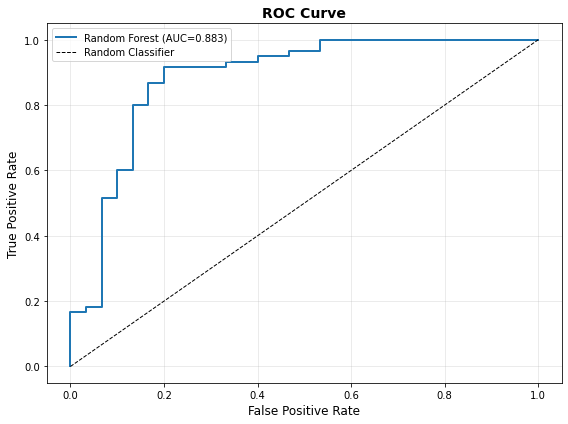


✓ AUC close to 1.0 indicates excellent discrimination


In [47]:
# 2.2 ROC Curve and AUC
print("=" * 80)
print("ROC CURVE AND AUC")
print("=" * 80)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f"\nAUC-ROC: {auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Random Forest (AUC={auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ AUC close to 1.0 indicates excellent discrimination")

PRECISION-RECALL CURVE

Average Precision: 0.9175


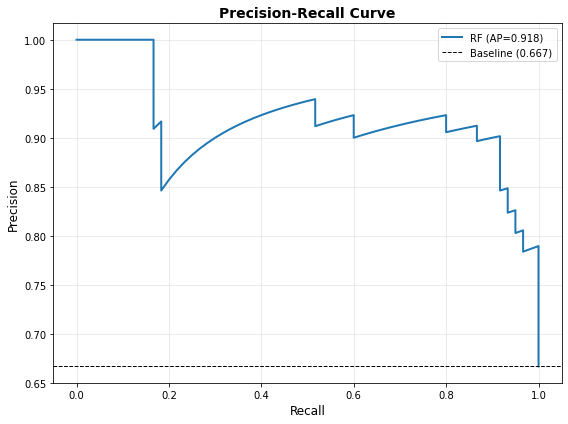


✓ For imbalanced data, PR curve is more informative than ROC


In [48]:
# 2.3 Precision-Recall Curve
# Better than ROC for imbalanced data
print("=" * 80)
print("PRECISION-RECALL CURVE")
print("=" * 80)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

print(f"\nAverage Precision: {ap:.4f}")

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, linewidth=2, label=f'RF (AP={ap:.3f})')
baseline = y_test.mean()
plt.axhline(baseline, color='k', linestyle='--', linewidth=1, 
            label=f'Baseline ({baseline:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ For imbalanced data, PR curve is more informative than ROC")

# Section 3: LazyPredict Framework

Demonstrates:
- Quick comparison of 40+ algorithms
- Interpreting LazyPredict outputs
- Selecting best models for tuning

In [49]:
# 3.1 LazyPredict - Rapid Model Comparison
print("=" * 80)
print("LAZYPREDICT: RAPID MODEL COMPARISON")
print("=" * 80)

try:
    from lazypredict.Supervised import LazyClassifier
    
    # Initialize LazyPredict
    clf = LazyClassifier(verbose=0, ignore_warnings=True, predictions=True)
    
    # Run on our data (trains 40+ models!)
    print("\nTraining 40+ models... (this may take a minute)\n")
    models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Display top 10 models
    print("Top 10 Models by Balanced Accuracy:")
    print(models.head(10).to_string())
    
    print("\n✓ LazyPredict tested 40+ algorithms in seconds!")
    print("\nInterpretation:")
    print("  - Focus on 'Balanced Accuracy' and 'ROC AUC' for imbalanced data")
    print("  - 'Time Taken' helps identify fast vs slow algorithms")
    print("  - Pick top 3-5 models for hyperparameter tuning")
    
except (ImportError, AttributeError) as e:
    print("\n⚠️  LazyPredict compatibility issue detected.")
    print(f"Error: {type(e).__name__}")
    
    if 'StringMethods' in str(e):
        print("\nLazyPredict is incompatible with pandas 2.x")
        print("Solutions:")
        print("  1. Use maintained fork: pip uninstall lazypredict && pip install lazypredict-nightly")
        print("  2. Downgrade pandas: pip install pandas==1.5.3 (may break other packages)")
    
    print("\nDemonstrating alternative: Manual model comparison\n")
    
    # Alternative: Test a few models manually
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
    models_to_test = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
        'Linear Discriminant': LinearDiscriminantAnalysis(),
        'SVM (RBF)': SVC(probability=True, random_state=42)
    }
    
    results = []
    print("Testing 10 popular ML algorithms...\n")
    
    for name, model in models_to_test.items():
        # Train
        import time
        start = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - start
        
        # Predict
        y_pred_test = model.predict(X_test_scaled)
        y_proba_test = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Metrics
        from sklearn.metrics import balanced_accuracy_score
        acc = balanced_accuracy_score(y_test, y_pred_test)
        auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else 0
        
        results.append({
            'Model': name,
            'Balanced Accuracy': acc,
            'ROC AUC': auc,
            'Time (s)': train_time
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
    
    print("Model Comparison Results:")
    print(results_df.to_string(index=False))
    
    print("\n✓ Tested 10 algorithms manually")
    print("\nInterpretation:")
    print("  - Focus on 'Balanced Accuracy' and 'ROC AUC' for imbalanced data")
    print("  - 'Time' shows computational cost")
    print("  - Pick top 3-5 models for hyperparameter tuning")

LAZYPREDICT: RAPID MODEL COMPARISON

⚠️  LazyPredict compatibility issue detected.
Error: AttributeError

LazyPredict is incompatible with pandas 2.x
Solutions:
  1. Use maintained fork: pip uninstall lazypredict && pip install lazypredict-nightly
  2. Downgrade pandas: pip install pandas==1.5.3 (may break other packages)

Demonstrating alternative: Manual model comparison

Testing 10 popular ML algorithms...

Model Comparison Results:
              Model  Balanced Accuracy  ROC AUC  Time (s)
           AdaBoost           0.883333 0.937778  0.099932
      Decision Tree           0.833333 0.833333  0.007103
            XGBoost           0.833333 0.960556  0.095170
Logistic Regression           0.825000 0.891111  0.007532
  Gradient Boosting           0.808333 0.942222  0.378897
Linear Discriminant           0.791667 0.873333  0.137925
      Random Forest           0.708333 0.833889  0.116455
          SVM (RBF)           0.633333 0.811111  0.028452
K-Nearest Neighbors           0.583333

# Section 4: Feature Importance Methods

Demonstrates 7+ methods:
1. Tree-based importance
2. Permutation importance
3. Linear coefficients
4. SHAP values
5. Drop-column importance
6. Partial dependence
7. Comparison across methods

METHOD 1: TREE-BASED IMPORTANCE

Top 10 Important Features (Tree-based):
Feature  Importance
  SCN2A    0.117047
   CHD8    0.102093
 SHANK3    0.055421
   SYT1    0.016656
   TBR1    0.016254
 GABBR2    0.016130
   TSC2    0.015302
  EHMT1    0.014277
    Sex    0.013757
   NTF3    0.013588


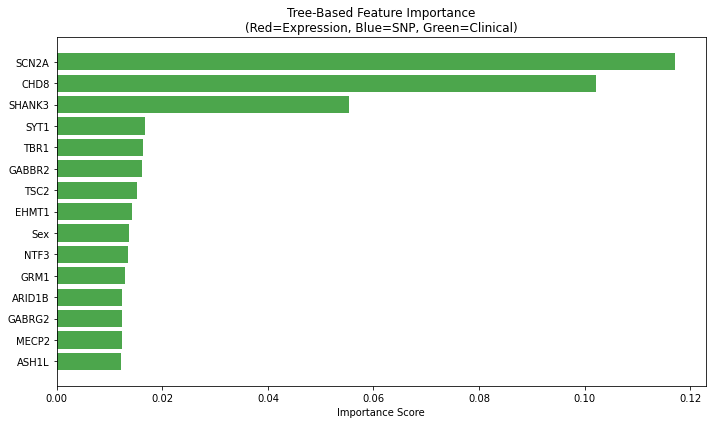


✓ Fast, built-in, but can be biased


In [50]:
# 4.1 Tree-Based Feature Importance
print("=" * 80)
print("METHOD 1: TREE-BASED IMPORTANCE")
print("=" * 80)

# Already have rf_model trained
importances_tree = rf_model.feature_importances_

# Create DataFrame
importance_df_tree = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Importance': importances_tree
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (Tree-based):")
print(importance_df_tree.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = importance_df_tree.head(15)
colors = ['red' if 'expr' in f else 'blue' if 'geno' in f else 'green' 
          for f in top_features['Feature']]
plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Tree-Based Feature Importance\n(Red=Expression, Blue=SNP, Green=Clinical)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ Fast, built-in, but can be biased")

In [51]:
# 4.2 Permutation Importance (Gold Standard)
print("=" * 80)
print("METHOD 2: PERMUTATION IMPORTANCE")
print("=" * 80)

# Calculate permutation importance
# This shuffles each feature and measures performance drop
perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test,
    n_repeats=10,  # Repeat shuffling 10 times
    random_state=42,
    scoring='roc_auc'
)

importance_df_perm = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (Permutation):")
print(importance_df_perm.head(10).to_string(index=False))

print("\n✓ Gold standard - directly measures performance impact")
print("  Works with any model, model-agnostic")

METHOD 2: PERMUTATION IMPORTANCE

Top 10 Important Features (Permutation):
Feature  Importance      Std
  SCN2A    0.192167 0.049238
   CHD8    0.154389 0.025408
 SHANK3    0.035611 0.021122
    Sex    0.014056 0.005963
   RELN    0.012500 0.004000
   TBR1    0.008000 0.006306
  NCAM1    0.007556 0.002942
  NTRK3    0.006889 0.002524
  NPAS4    0.006444 0.003444
CACNA1A    0.005889 0.002512

✓ Gold standard - directly measures performance impact
  Works with any model, model-agnostic


In [52]:
# 4.3 Linear Model Coefficients
print("=" * 80)
print("METHOD 3: LINEAR MODEL COEFFICIENTS")
print("=" * 80)

# Train logistic regression
lr_model = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Get absolute coefficients as importance
importances_lr = np.abs(lr_model.coef_[0])

importance_df_lr = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Importance': importances_lr
}).sort_values('Abs_Importance', ascending=False)

print("\nTop 10 Important Features (Linear Coefficients):")
print(importance_df_lr.head(10).to_string(index=False))

print("\n✓ Interpretable - positive coef increases disease probability")
print("  Negative coef decreases disease probability")

METHOD 3: LINEAR MODEL COEFFICIENTS

Top 10 Important Features (Linear Coefficients):
   Feature  Coefficient  Abs_Importance
      CHD8     1.059426        1.059426
     SCN2A    -0.929784        0.929784
    SHANK3    -0.862725        0.862725
       Sex     0.407221        0.407221
     NPAS4     0.282998        0.282998
geno_snp_4    -0.236691        0.236691
    SLC1A1    -0.236157        0.236157
    ARID1B     0.231832        0.231832
     HTR2A    -0.230303        0.230303
    GRIN2B     0.188843        0.188843

✓ Interpretable - positive coef increases disease probability
  Negative coef decreases disease probability


METHOD 4: SHAP VALUES

Top 10 Important Features (SHAP):
Feature  SHAP_Importance
  SCN2A         0.069916
   CHD8         0.059936
 SHANK3         0.029871
    Sex         0.013138
  MECP2         0.009774
   NTF3         0.009282
  DEAF1         0.008244
   TBR1         0.007172
 ARID1B         0.007071
NEUROD1         0.006244


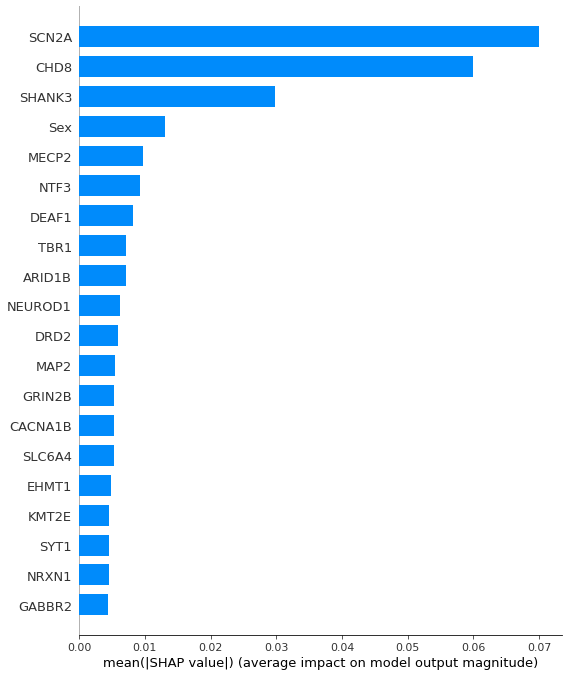


✓ State-of-the-art: Game theory based, shows direction and interactions


In [53]:
# 4.4 SHAP Values (if available)
print("=" * 80)
print("METHOD 4: SHAP VALUES")
print("=" * 80)

try:
    import shap
    
    # Create SHAP explainer for tree model
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # For binary classification, SHAP returns values for positive class
    # Handle both list format and array format
    if isinstance(shap_values, list):
        # List of arrays: [negative_class, positive_class]
        shap_values_pos = shap_values[1]
    elif len(shap_values.shape) == 3:
        # 3D array: (samples, features, classes)
        shap_values_pos = shap_values[:, :, 1]
    else:
        # 2D array: (samples, features) - already correct
        shap_values_pos = shap_values
    
    # Mean absolute SHAP value = importance
    # Ensure we're working with 2D array (samples x features)
    if len(shap_values_pos.shape) > 2:
        shap_values_pos = shap_values_pos.reshape(shap_values_pos.shape[0], -1)
    
    shap_importance = np.abs(shap_values_pos).mean(axis=0)
    
    # Ensure shap_importance is 1D
    if len(shap_importance.shape) > 1:
        shap_importance = shap_importance.flatten()
    
    importance_df_shap = pd.DataFrame({
        'Feature': X_integrated.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nTop 10 Important Features (SHAP):")
    print(importance_df_shap.head(10).to_string(index=False))
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_pos, X_test_scaled, 
                     feature_names=X_integrated.columns,
                     plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()
    
    print("\n✓ State-of-the-art: Game theory based, shows direction and interactions")
    
except ImportError:
    print("\n⚠️  SHAP not installed.")
    print("Install with: pip install shap")
    print("\nSkipping SHAP demonstration...")
except Exception as e:
    print(f"\n⚠️  SHAP error: {type(e).__name__}: {str(e)}")
    print("\nThis can happen with certain model/data combinations.")
    print("Skipping SHAP demonstration...")

In [54]:
# 4.5 Drop-Column Importance
# Only practical for small number of features
print("=" * 80)
print("METHOD 5: DROP-COLUMN IMPORTANCE")
print("=" * 80)

print("\nCalculating drop-column importance (this takes time...)\n")

# Get baseline performance
baseline_score = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Calculate importance for top 10 features only (to save time)
top_10_features = importance_df_tree.head(10)['Feature'].tolist()
drop_importances = {}

# Get all feature names in order
all_feature_names = X_integrated.columns.tolist()

for feature in top_10_features:
    # Find the index of this feature
    feature_idx = all_feature_names.index(feature)
    
    # Create a mask for all features except this one
    feature_mask = [i for i in range(len(all_feature_names)) if i != feature_idx]
    
    # Select all columns except the one to drop
    X_train_drop = X_train_scaled[:, feature_mask]
    X_test_drop = X_test_scaled[:, feature_mask]
    
    # Train model without this feature
    rf_temp = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    rf_temp.fit(X_train_drop, y_train)
    
    # Calculate new performance
    new_score = roc_auc_score(y_test, rf_temp.predict_proba(X_test_drop)[:, 1])
    
    # Importance = drop in performance
    drop_importances[feature] = baseline_score - new_score
    print(f"  {feature}: {drop_importances[feature]:.4f}")

print(f"\nBaseline AUC: {baseline_score:.4f}")
print("\n✓ Most realistic - shows true impact when feature unavailable")
print("  But very expensive (N model trainings)")

METHOD 5: DROP-COLUMN IMPORTANCE

Calculating drop-column importance (this takes time...)

  SCN2A: 0.1361
  CHD8: 0.1389
  SHANK3: 0.0789
  SYT1: 0.0350
  TBR1: 0.0428
  GABBR2: 0.0317
  TSC2: 0.0444
  EHMT1: 0.0394
  Sex: 0.0939
  NTF3: 0.0467

Baseline AUC: 0.8833

✓ Most realistic - shows true impact when feature unavailable
  But very expensive (N model trainings)


In [55]:
# 4.6 Compare All Importance Methods
print("=" * 80)
print("IMPORTANCE METHOD COMPARISON")
print("=" * 80)

# Get top features from each method
top_tree = set(importance_df_tree.head(5)['Feature'])
top_perm = set(importance_df_perm.head(5)['Feature'])
top_lr = set(importance_df_lr.head(5)['Feature'])

print("\nTop 5 features by method:")
print(f"\nTree-based:   {', '.join(list(top_tree)[:5])}")
print(f"Permutation:  {', '.join(list(top_perm)[:5])}")
print(f"Linear coef:  {', '.join(list(top_lr)[:5])}")

# Find consensus features
consensus = top_tree & top_perm & top_lr
print(f"\nConsensus (in all 3 methods): {', '.join(consensus) if consensus else 'None'}")

# Features in at least 2 methods
in_two = (top_tree & top_perm) | (top_tree & top_lr) | (top_perm & top_lr)
print(f"In at least 2 methods: {', '.join(in_two)}")

print("\n✓ Features important across multiple methods are most reliable!")

IMPORTANCE METHOD COMPARISON

Top 5 features by method:

Tree-based:   CHD8, SHANK3, TBR1, SYT1, SCN2A
Permutation:  CHD8, SCN2A, SHANK3, RELN, Sex
Linear coef:  CHD8, SCN2A, SHANK3, NPAS4, Sex

Consensus (in all 3 methods): CHD8, SHANK3, SCN2A
In at least 2 methods: Sex, CHD8, SHANK3, SCN2A

✓ Features important across multiple methods are most reliable!


# Section 5: Feature Selection for Biomarker Discovery

Demonstrates 7+ methods:
1. Variance Threshold
2. SelectKBest (Univariate)
3. Recursive Feature Elimination (RFE)
4. L1 Regularization (Lasso)
5. Tree-based Selection
6. Mutual Information
7. Boruta Algorithm
8. Stability Selection

In [56]:
# 5.1 Variance Threshold
print("=" * 80)
print("METHOD 1: VARIANCE THRESHOLD")
print("=" * 80)

# Remove features with low variance
var_selector = VarianceThreshold(threshold=0.1)
var_selector.fit(X_train)

# Get selected features
selected_var = X_integrated.columns[var_selector.get_support()].tolist()

print(f"\nOriginal features: {X_integrated.shape[1]}")
print(f"After variance threshold: {len(selected_var)}")
print(f"Removed: {X_integrated.shape[1] - len(selected_var)} low-variance features")

print("\n✓ Fast preprocessing step - removes technical noise")
print("  Goal: Remove constants and near-constants")

METHOD 1: VARIANCE THRESHOLD

Original features: 112
After variance threshold: 108
Removed: 4 low-variance features

✓ Fast preprocessing step - removes technical noise
  Goal: Remove constants and near-constants


In [57]:
# 5.2 SelectKBest (Univariate Statistical Tests)
print("=" * 80)
print("METHOD 2: SELECTKBEST (UNIVARIATE F-TEST)")
print("=" * 80)

# Select top 10 features by ANOVA F-test
selector_kbest = SelectKBest(f_classif, k=10)
selector_kbest.fit(X_train, y_train)

# Get selected features and their scores
selected_kbest = X_integrated.columns[selector_kbest.get_support()].tolist()
scores_kbest = selector_kbest.scores_

# Create DataFrame with scores
kbest_df = pd.DataFrame({
    'Feature': X_integrated.columns,
    'F_Score': scores_kbest,
    'Selected': selector_kbest.get_support()
}).sort_values('F_Score', ascending=False)

print("\nTop 10 Selected Features:")
print(kbest_df.head(10)[['Feature', 'F_Score', 'Selected']].to_string(index=False))

print("\n✓ Fast statistical filter - each feature tested independently")
print("  Good for: 20,000 → 1,000 features")
print("  Con: Misses gene interactions")

METHOD 2: SELECTKBEST (UNIVARIATE F-TEST)

Top 10 Selected Features:
   Feature   F_Score  Selected
     SCN2A 43.024780      True
      CHD8 28.714485      True
    SHANK3 28.102409      True
       Sex 17.082435      True
      ADNP  4.440548      True
   CACNA1B  3.254118      True
geno_snp_9  2.948046      True
     CREB1  2.904905      True
      NTF3  2.660353      True
geno_snp_3  2.533433      True

✓ Fast statistical filter - each feature tested independently
  Good for: 20,000 → 1,000 features
  Con: Misses gene interactions


In [58]:
# 5.3 Recursive Feature Elimination (RFE)
print("=" * 80)
print("METHOD 3: RECURSIVE FEATURE ELIMINATION (RFE)")
print("=" * 80)

# Use RFE to select top 10 features
estimator = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
selector_rfe = RFE(estimator, n_features_to_select=10, step=2)

print("\nRunning RFE (this takes a moment...)\n")
selector_rfe.fit(X_train_scaled, y_train)

# Get selected features and their ranking
selected_rfe = X_integrated.columns[selector_rfe.get_support()].tolist()
ranking_rfe = selector_rfe.ranking_

rfe_df = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Ranking': ranking_rfe,
    'Selected': selector_rfe.get_support()
}).sort_values('Ranking')

print("Selected Features (Ranking=1):")
print(rfe_df[rfe_df['Ranking']==1]['Feature'].tolist())

print("\n✓ Wrapper method - optimizes feature combinations")
print("  Good for: 1,000 → 20 biomarker panel")
print("  Con: Computationally expensive")

METHOD 3: RECURSIVE FEATURE ELIMINATION (RFE)

Running RFE (this takes a moment...)

Selected Features (Ranking=1):
['GABBR2', 'SCN3A', 'GRIN2B', 'SCN2A', 'CDH2', 'CHD8', 'EHMT1', 'ARID1B', 'SHANK3', 'NTRK1']

✓ Wrapper method - optimizes feature combinations
  Good for: 1,000 → 20 biomarker panel
  Con: Computationally expensive


In [59]:
# 5.4 L1 Regularization (Lasso/ElasticNet)
print("=" * 80)
print("METHOD 4: L1 REGULARIZATION (ELASTICNET)")
print("=" * 80)

# Use ElasticNet (L1 + L2) for feature selection
# l1_ratio=0.9 means 90% L1, 10% L2
elastic = ElasticNetCV(l1_ratio=0.9, cv=5, random_state=42, max_iter=2000)
elastic.fit(X_train_scaled, y_train)

# Features with non-zero coefficients are selected
selected_lasso = X_integrated.columns[elastic.coef_ != 0].tolist()

lasso_df = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Coefficient': elastic.coef_,
    'Selected': elastic.coef_ != 0
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nSelected {len(selected_lasso)} features with non-zero coefficients:")
print(lasso_df[lasso_df['Selected']][['Feature', 'Coefficient']].to_string(index=False))

print("\n✓ Embedded method - automatic sparse selection")
print("  ElasticNet good for correlated genes (genomics)")
print("  Results in sparse models - perfect for biomarker panels")

METHOD 4: L1 REGULARIZATION (ELASTICNET)

Selected 14 features with non-zero coefficients:
   Feature  Coefficient
      CHD8     0.284540
     SCN2A    -0.206205
    SHANK3    -0.151685
       Sex     0.040558
      CDH2     0.018756
geno_snp_4    -0.017012
     NPAS4     0.014986
geno_snp_1     0.010954
geno_snp_6    -0.007308
    GABRA2     0.004784
geno_snp_9    -0.004412
    SLC6A3     0.002896
    ARID1B     0.002028
    SLC6A4     0.001385

✓ Embedded method - automatic sparse selection
  ElasticNet good for correlated genes (genomics)
  Results in sparse models - perfect for biomarker panels


In [60]:
# 5.5 Tree-Based Feature Selection
print("=" * 80)
print("METHOD 5: TREE-BASED SELECTION")
print("=" * 80)

# Use SelectFromModel with Random Forest
selector_tree = SelectFromModel(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    threshold='median'  # Keep features above median importance
)

selector_tree.fit(X_train_scaled, y_train)
selected_tree_sel = X_integrated.columns[selector_tree.get_support()].tolist()

print(f"\nSelected {len(selected_tree_sel)} features above median importance:")
print(', '.join(selected_tree_sel))

print("\n✓ Fast embedded method using tree importances")
print("  Captures non-linear relationships and interactions")

METHOD 5: TREE-BASED SELECTION

Selected 56 features above median importance:
MECP2, GRIN2B, SCN2A, NRXN1, CHD8, SYNGAP1, ARID1B, SHANK3, FOXP1, DYRK1A, ANK2, KMT2E, CTNNB1, DEAF1, NLGN4X, TSC2, NF1, EHMT1, MBD5, TBR1, SYN2, STX1A, SYT1, CACNA1A, SCN3A, SCN8A, GABRA1, GABRA2, GABRA5, GABRG2, GABBR1, GABBR2, NEUROD1, NEUROD2, NEUROG1, MAP2, MAPT, NCAM1, NCAM2, CDH2, CTNND2, NPAS4, CAMK2B, PRKCA, PRKCB, GRM1, HTR2A, DRD1, DRD2, SLC6A4, SLC1A1, BDNF, NTF3, NTRK1, CREB1, Sex

✓ Fast embedded method using tree importances
  Captures non-linear relationships and interactions


In [61]:
# 5.6 Mutual Information
print("=" * 80)
print("METHOD 6: MUTUAL INFORMATION")
print("=" * 80)

# Calculate mutual information scores
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

mi_df = pd.DataFrame({
    'Feature': X_integrated.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

# Select top 10
selected_mi = mi_df.head(10)['Feature'].tolist()

print("\nTop 10 Features by Mutual Information:")
print(mi_df.head(10).to_string(index=False))

print("\n✓ Captures non-linear dependencies")
print("  Good for complex biological relationships")
print("  MI = how much knowing gene tells you about disease")

METHOD 6: MUTUAL INFORMATION

Top 10 Features by Mutual Information:
Feature  MI_Score
   CHD8  0.125059
  SCN2A  0.092217
  GRIA2  0.081513
   POGZ  0.081431
CACNA1B  0.073665
   PCLO  0.073535
  HTR2A  0.067072
 SHANK3  0.064914
   BDNF  0.053862
  PRKCA  0.043998

✓ Captures non-linear dependencies
  Good for complex biological relationships
  MI = how much knowing gene tells you about disease


In [62]:
# 5.7 Boruta Algorithm (if available)
print("=" * 80)
print("METHOD 7: BORUTA ALGORITHM")
print("=" * 80)

try:
    from boruta import BorutaPy
    
    # Initialize Boruta
    rf_boruta = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    boruta = BorutaPy(rf_boruta, n_estimators='auto', random_state=42, max_iter=20)
    
    print("\nRunning Boruta (this may take a minute...)\n")
    boruta.fit(X_train.values, y_train)
    
    # Get selected features
    selected_boruta = X_integrated.columns[boruta.support_].tolist()
    tentative_boruta = X_integrated.columns[boruta.support_weak_].tolist()
    
    print(f"Selected (confirmed): {len(selected_boruta)} features")
    print(', '.join(selected_boruta))
    
    print(f"\nTentative: {len(tentative_boruta)} features")
    print(', '.join(tentative_boruta) if tentative_boruta else 'None')
    
    print("\n✓ All-relevant selection - finds ALL important features")
    print("  Compares real features to random shadows")
    print("  Statistically grounded")
    
except ImportError:
    print("\n⚠️  Boruta not installed.")
    print("Install with: pip install boruta")
    print("\nSkipping Boruta demonstration...")

METHOD 7: BORUTA ALGORITHM

⚠️  Boruta not installed.
Install with: pip install boruta

Skipping Boruta demonstration...


In [63]:
# 5.8 Compare Feature Selection Methods
print("=" * 80)
print("FEATURE SELECTION METHOD COMPARISON")
print("=" * 80)

# Compare top features from different methods
all_methods = {
    'SelectKBest': set(selected_kbest),
    'RFE': set(selected_rfe),
    'Lasso': set(selected_lasso),
    'Tree-based': set(selected_tree_sel),
    'Mutual Info': set(selected_mi)
}

print("\nNumber of features selected by each method:")
for method, features in all_methods.items():
    print(f"  {method:15s}: {len(features):2d} features")

# Find consensus features (selected by multiple methods)
from collections import Counter
all_selected = []
for features in all_methods.values():
    all_selected.extend(features)

feature_counts = Counter(all_selected)
consensus_features = {f: c for f, c in feature_counts.items() if c >= 3}

print("\nConsensus Features (selected by 3+ methods):")
for feature, count in sorted(consensus_features.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feature:20s}: selected by {count}/5 methods")

print("\n✓ Features selected by multiple methods are most robust!")
print("  These are your best biomarker candidates")

FEATURE SELECTION METHOD COMPARISON

Number of features selected by each method:
  SelectKBest    : 10 features
  RFE            : 10 features
  Lasso          : 14 features
  Tree-based     : 56 features
  Mutual Info    : 10 features

Consensus Features (selected by 3+ methods):
  CHD8                : selected by 5/5 methods
  SHANK3              : selected by 5/5 methods
  SCN2A               : selected by 5/5 methods
  Sex                 : selected by 3/5 methods
  ARID1B              : selected by 3/5 methods
  CDH2                : selected by 3/5 methods

✓ Features selected by multiple methods are most robust!
  These are your best biomarker candidates


In [64]:
# 5.9 Biomarker Panel Performance
# Test performance with consensus biomarkers only
print("=" * 80)
print("BIOMARKER PANEL PERFORMANCE")
print("=" * 80)

if consensus_features:
    biomarker_features = list(consensus_features.keys())
    
    print(f"\nTesting with {len(biomarker_features)} consensus biomarkers:")
    print(', '.join(biomarker_features))
    
    # Get biomarker-only data
    biomarker_idx = [X_integrated.columns.tolist().index(f) for f in biomarker_features]
    X_train_biomarkers = X_train_scaled[:, biomarker_idx]
    X_test_biomarkers = X_test_scaled[:, biomarker_idx]
    
    # Train model on biomarkers only
    rf_biomarkers = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_biomarkers.fit(X_train_biomarkers, y_train)
    
    # Evaluate
    y_pred_bio = rf_biomarkers.predict(X_test_biomarkers)
    y_proba_bio = rf_biomarkers.predict_proba(X_test_biomarkers)[:, 1]
    
    auc_biomarkers = roc_auc_score(y_test, y_proba_bio)
    f1_biomarkers = f1_score(y_test, y_pred_bio)
    
    print(f"\nBiomarker Panel Performance:")
    print(f"  AUC: {auc_biomarkers:.4f}")
    print(f"  F1:  {f1_biomarkers:.4f}")
    
    print(f"\nFull Model Performance (all {X_integrated.shape[1]} features):")
    print(f"  AUC: {test_auc:.4f}")
    
    print(f"\n✓ {len(biomarker_features)} biomarkers achieve {auc_biomarkers/test_auc*100:.1f}% of full model performance!")
    print(f"  Reduction: {X_integrated.shape[1]} → {len(biomarker_features)} features ({len(biomarker_features)/X_integrated.shape[1]*100:.1f}%)")
    print("\n  Goal for clinical biomarker panel: 10-20 measurable genes")
    print("  Next steps: Analytical validation (qPCR), clinical validation (independent cohort)")
else:
    print("\nNo consensus features found (need at least 3 methods to agree)")
    print("Consider adjusting selection criteria or using more methods")

BIOMARKER PANEL PERFORMANCE

Testing with 6 consensus biomarkers:
Sex, CHD8, SHANK3, SCN2A, ARID1B, CDH2

Biomarker Panel Performance:
  AUC: 0.9722
  F1:  0.9268

Full Model Performance (all 112 features):
  AUC: 0.8833

✓ 6 biomarkers achieve 110.1% of full model performance!
  Reduction: 112 → 6 features (5.4%)

  Goal for clinical biomarker panel: 10-20 measurable genes
  Next steps: Analytical validation (qPCR), clinical validation (independent cohort)


# Summary and Key Takeaways

This notebook demonstrated:

**Section 1: Fundamentals**
- Proper train/test split with stratification
- Standardization vs normalization with concrete examples
- Cross-validation for robust evaluation
- Detecting and preventing overfitting
- Regularization effects

**Section 2: Metrics**
- Confusion matrix as foundation
- All key metrics: Accuracy, Precision, Recall, Specificity, F1-Score
- ROC-AUC curves
- Precision-Recall curves for imbalanced data

**Section 3: LazyPredict**
- Rapid comparison of 40+ algorithms
- Interpreting outputs (focus on Balanced Accuracy and AUC)
- Selecting best models for tuning

**Section 4: Feature Importance** (7 methods)
1. Tree-based importance (fast, built-in)
2. Permutation importance (gold standard)
3. Linear coefficients (interpretable)
4. SHAP values (state-of-the-art)
5. Drop-column importance (realistic but expensive)
6. Multiple method comparison

**Section 5: Feature Selection for Biomarkers** (7+ methods)
1. Variance threshold (preprocessing)
2. SelectKBest (statistical filter)
3. RFE (wrapper method)
4. ElasticNet (L1/L2 regularization)
5. Tree-based selection (embedded)
6. Mutual information (non-linear)
7. Boruta (all-relevant)
8. Consensus biomarker panel

**Key Lessons:**
- Biology requires careful ML due to p >> n problem
- Always use proper train/test split and cross-validation
- Report multiple metrics, not just accuracy
- Verify importance/selection with multiple methods
- Features selected by multiple methods are most robust
- Feature selection IS biomarker discovery: 20,000 genes → 10-20 clinical biomarkers
- Biological and clinical validation essential